In [71]:
#importing packages
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from sklearn.cluster import KMeans
import os
import talib
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import math
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA  # to apply PCA
import pandas_ta as ta
from mrmr import mrmr_classif
from sklearn.preprocessing import Normalizer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import StratifiedKFold

In [2]:
resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]


The following companey is not available any more so I removed it from the tickers list

In [3]:
tickers.remove('BRK.B')

## Download all the price history of the top 100 companies in the US market. I chosed to train the model on the last three years given that data would more consistent than it would be for a larger period of time. 

In [25]:
yf.pdr_override()
alldata=pd.DataFrame()
i=1
for ticker in tickers:#len(tickers)):
    print(ticker)
    data_s=pdr.get_data_yahoo(ticker, start='2002-1-1', end='2023-07-14')
    data_s["Ticker"]=ticker
    data_s["Asset_ID"]=i
    alldata=pd.concat([alldata, data_s])
    i+=1

AAPL
[*********************100%***********************]  1 of 1 completed
ABBV
[*********************100%***********************]  1 of 1 completed
ABT
[*********************100%***********************]  1 of 1 completed
ACN
[*********************100%***********************]  1 of 1 completed
ADBE
[*********************100%***********************]  1 of 1 completed
AIG
[*********************100%***********************]  1 of 1 completed
AMD
[*********************100%***********************]  1 of 1 completed
AMGN
[*********************100%***********************]  1 of 1 completed
AMT
[*********************100%***********************]  1 of 1 completed
AMZN
[*********************100%***********************]  1 of 1 completed
AVGO
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
BA
[*********************100%***********************]  1 of 1 completed
BAC
[*********************100%****************

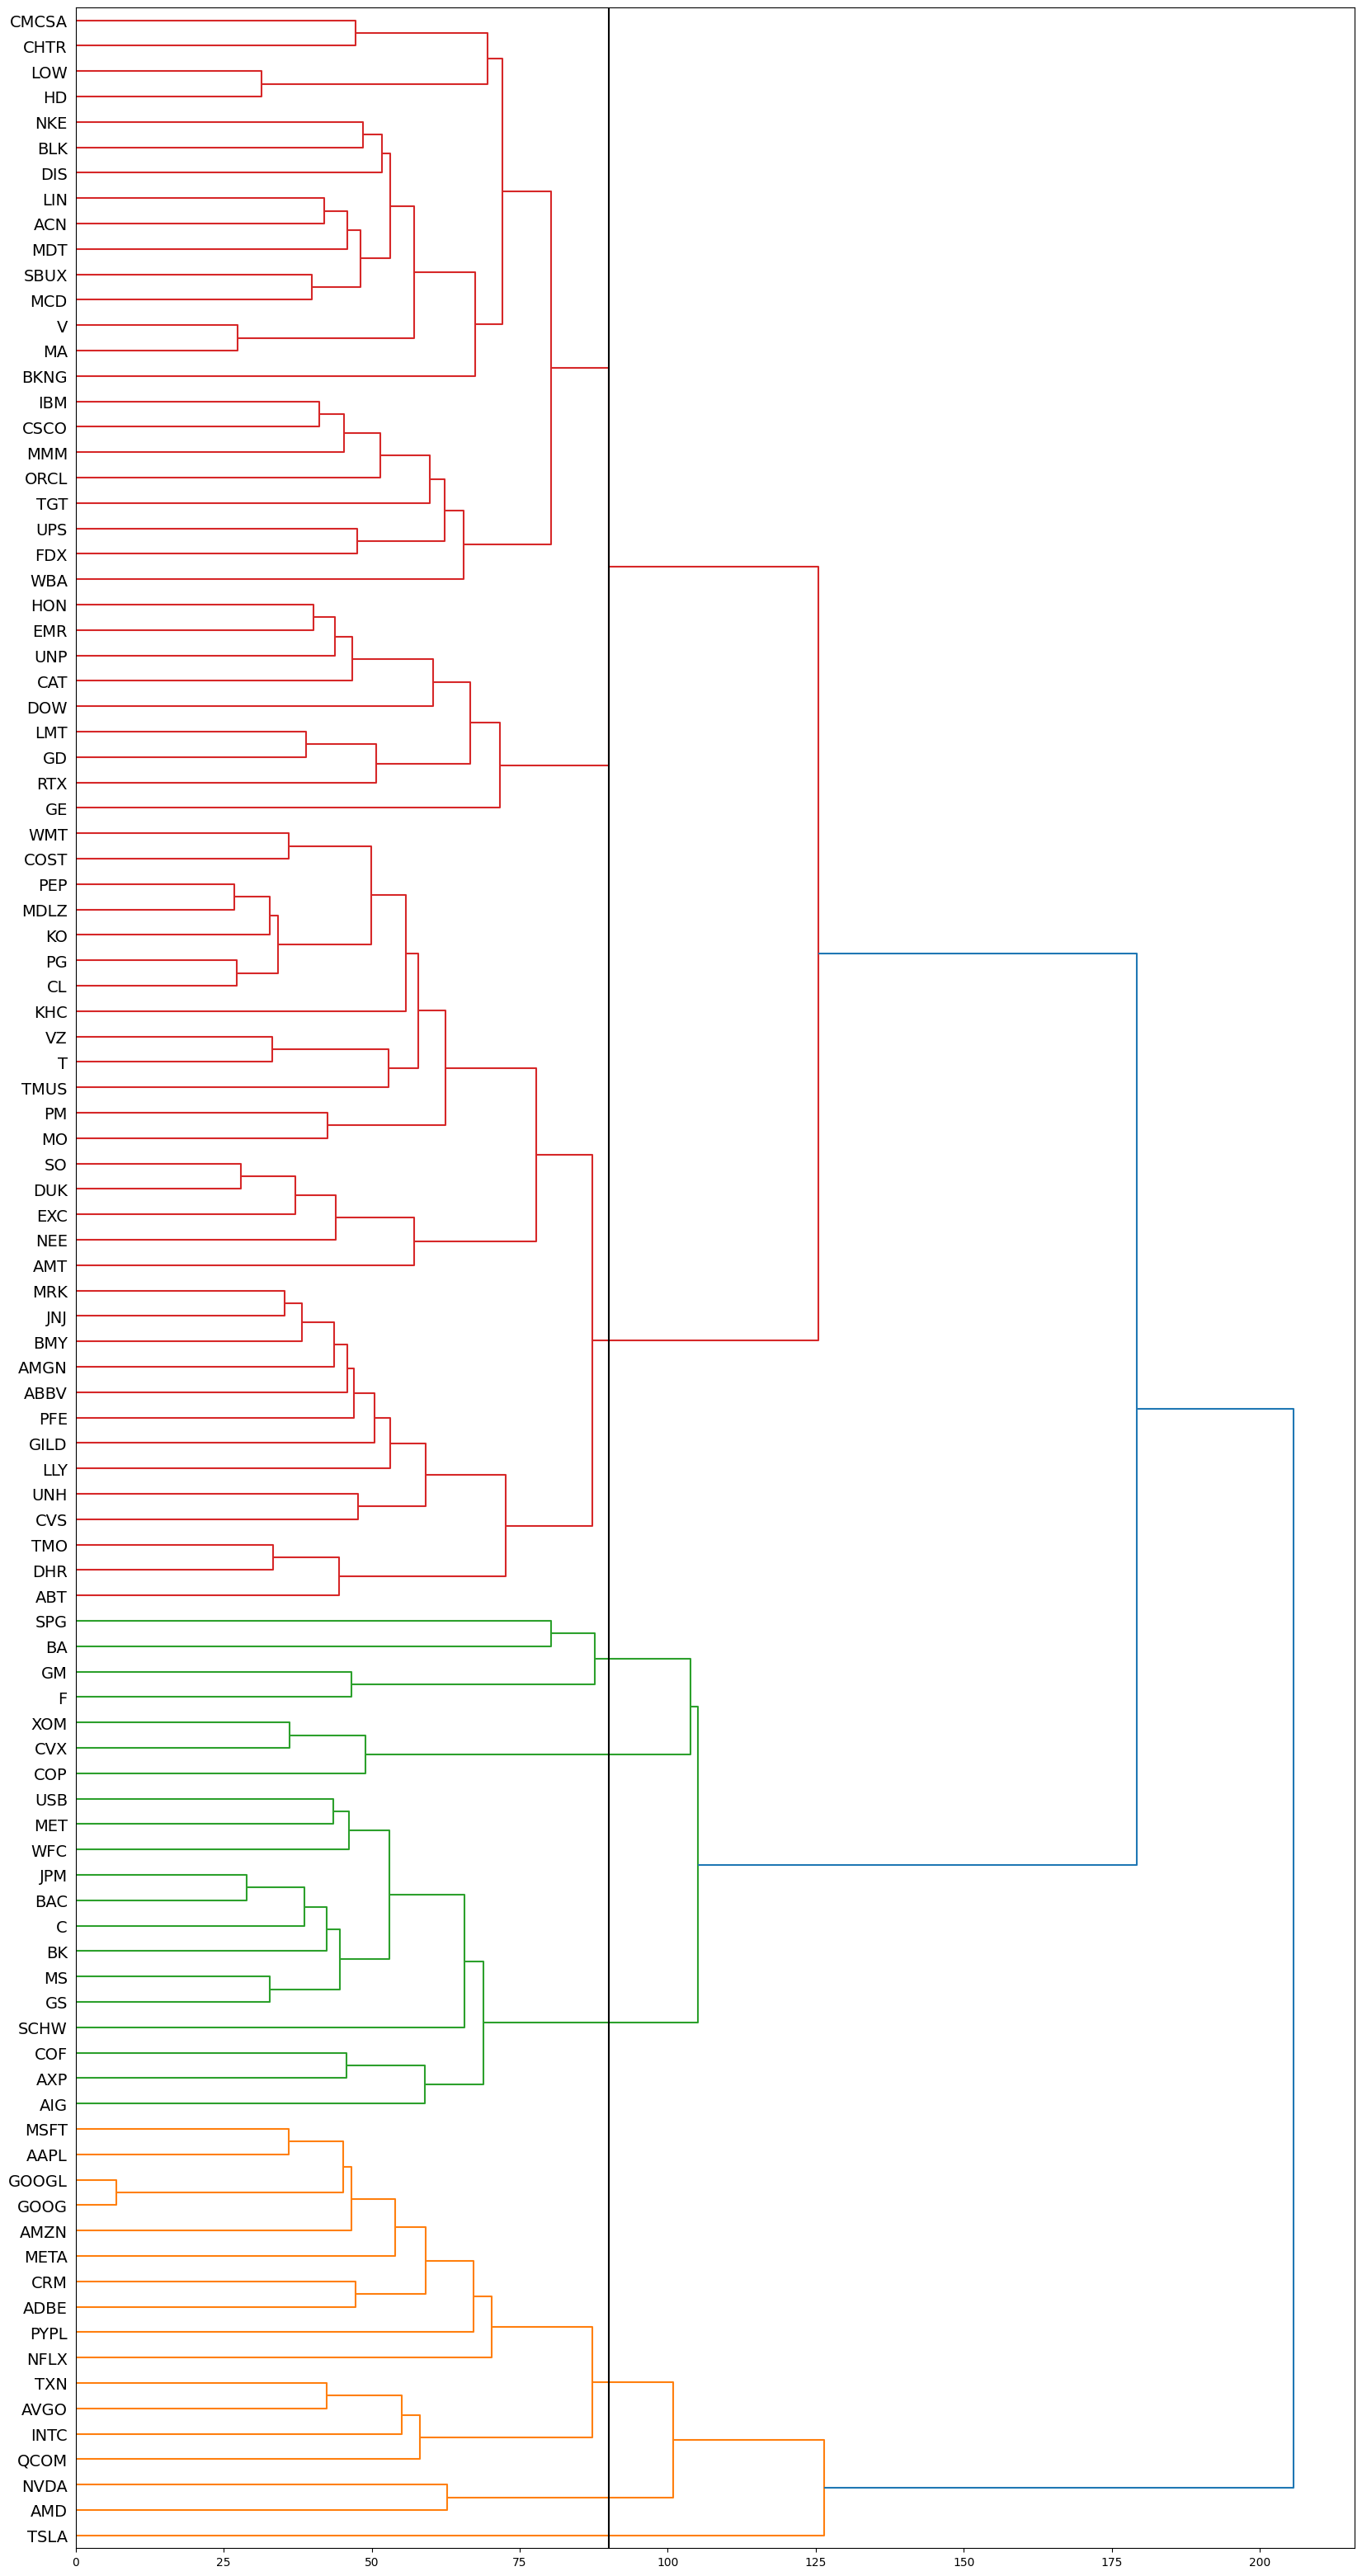

In [26]:
import numpy as np
import matplotlib.pyplot as plt
ss=alldata.copy()
ss["movement"]=(ss["Open"]-ss["Close"])/ss["Open"]*100
ss["Date"]=ss.index
transposed = ss.pivot(index = 'Date', columns = 'Ticker', values = 'movement')
X=transposed.dropna().transpose()
labels=list(X.index)
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(figsize = (20,40))
linkage_data = linkage(X, method='ward', metric='euclidean')
dendrogram(linkage_data,orientation="right",leaf_font_size=14,labels=labels)
plt.axvline(x=90, c='k')
plt.show() 

# Data feturizing using technical analysis indicators

I will be using ta-lib library to calculate various technical analysis indicators

In [27]:
def volume(df):
        high=df["High"]
        low=df["Low"]
        close=df["Close"]
        volume=df["Volume"]
        df["AD"]= talib.AD(high, low, close, volume)
        df["ADOSC"]= talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        df["OBV"]= talib.OBV(close, volume)
        return df
def momentum(df): 
        highs=df["High"]
        opens=df["Open"]
        lows=df["Low"]
        closes=df["Close"]
        volume=df["Volume"]
        df["CMO"]= talib.CMO(closes)       
        df["MOM"]= talib.MOM(closes)
        df["ROC"]= talib.ROC(closes)
        df["ROCP"]= talib.ROCP(closes)
        df["ROCR"]= talib.ROCR(closes)
        df["ROCR100"]= talib.ROCR100(closes)
        df["RSI"]= talib.RSI(closes)
        df["TRIX_"]= talib.TRIX(closes)
        df["ADX"]=talib.ADX(highs,lows,closes)
        df["ADXR"]=talib.ADXR(highs,lows,closes)
        df["AROONdown"],df["AROONup"]= talib.AROON(highs, lows)
        df["AROONOSC"]= talib.AROONOSC(highs, lows)  
        df["CCI"]= talib.CCI(highs, lows, closes)
        df["DX"]= talib.DX(highs, lows, closes)
        df["MFI"]= talib.MFI(highs, lows, closes, volume)        
        df["MINUS_DI"]= talib.MINUS_DI(highs, lows, closes)
        df["MINUS_DM"]= talib.MINUS_DM(highs, lows)
        df["PLUS_DI"]= talib.PLUS_DI(highs, lows, closes)
        df["PLUS_DM"]= talib.PLUS_DM(highs, lows)
        df["ULTOSC"]= talib.ULTOSC(highs, lows, closes)
        df["WILLR"]= talib.WILLR(highs, lows, closes)
        df["BOP"]= talib.BOP(opens, highs, lows, closes)
        df["STOCH"+"_fast"], df["STOCH"+"_slow"] = talib.STOCH(highs, lows, closes, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)  
        df["STOCHF"+"_fast"], df["STOCHF"+"_slow"] = talib.STOCHF(highs, lows, closes, fastk_period=5, fastd_period=3, fastd_matype=0)    
        #df["MACD"], df["MACD"+"_signal]"],df["MACD"+"_hist]"]  = talib.MACD(closes)
        #df["MACDEXT"], df["MACDEXT"+"_signal]"],df["MACDEXT"+"_hist]"]  = talib.MACDEXT(closes)
        df["MACDFIX"], df["MACDFIX"+"_signal]"],df["MACDFIX"+"_hist]"]  = talib.MACDFIX(closes)
        df["PPO"]= talib.PPO(closes)
        df["APO"]=talib.APO(closes)
        df["STOCHRSIfast"], df["STOCHRSIslow"] = talib.STOCHRSI(closes)
        return df
    
def volatility(df):
        highs=df["High"]
        lows=df["Low"]
        closes=df["Close"]
        df["ATR"]= talib.ATR(highs, lows, closes)
        df["NATR"]= talib.NATR(highs, lows, closes)
        df["TRANGE"]= talib.TRANGE(highs, lows, closes)
        return df

    
def price(df):
        opens=df["Open"]
        highs=df["High"]
        lows=df["Low"]
        closes=df["Close"]
        #df["AVGPRICE"]= talib.AVGPRICE(opens, highs, lows, closes)
        df["MEDPRICE"]= talib.MEDPRICE(highs, lows)
        #df["TYPRICE"]= talib.TYPPRICE(highs, lows, closes)
        #df["WCLPRICE"]= talib.WCLPRICE(highs, lows, closes)
        df["LINEARREG"]= talib.LINEARREG(closes)
        return df


def overlap(df):
        opens=df["Open"]
        highs=df["High"]
        lows=df["Low"]
        closes=df["Close"]
        df["BBupperband"], df["BBmiddleband"], df["BBlowerband"] = talib.BBANDS(closes)
        df["DEMA"] = talib.DEMA(closes)
        df["EMA"] = talib.EMA(closes)
        df["ht"] = talib.HT_TRENDLINE(closes)
        df["KAMA"]=talib.KAMA(closes)
        df["SMA"]=talib.SMA(closes)
        df["MA"]=talib.MA(closes)
        df["MAMA"],df["fama"]=talib.MAMA(closes)
        #df["MAVP"]=talib.MAVP(closes)
        df["MDPT"]=talib.MIDPOINT(closes)
        df["MDPRICE"]=talib.MIDPRICE(highs,lows)
        df["SAR"]=talib.SAR(highs,lows)                       
        df["SAREXT"]=talib.SAREXT(highs,lows)      
        df["T3"]=talib.T3(closes)
        df["TEMA"]=talib.SMA(closes)
        df["TRIMA"]=talib.TRIMA(closes)
        df["WMA"]=talib.WMA(closes)
        return df
    
def candles(df):
        opens=df["Open"]
        high=df["High"]
        low=df["Low"]
        close=df["Close"]
        df["HT_DCPERIOD"]= talib.HT_DCPERIOD(close)
        df["HT_DCPHASE"]= talib.HT_DCPHASE(close)
        df["HT_PHASOR"+"_inphase"],df["HT_PHASOR"+"_quadrature"]=talib.HT_PHASOR(close)
        df["HT_SINE"+"_sine"],df["HT_SINE"+"_leadsine"]= talib.HT_SINE(close)
        df["HT_TRENDMODE"]= talib.HT_TRENDMODE(close)
        df["CDL2CROWS"]= talib.CDL2CROWS(opens, high, low, close)
        df["CDL3BLACKCROWS"]= talib.CDL3BLACKCROWS(opens, high, low, close)
        df["CDL3INSIDE"]= talib.CDL3INSIDE(opens, high, low, close)
        df["CDL3LINESTRIKE"]= talib.CDL3LINESTRIKE(opens, high, low, close)
        df["CDL3OUTSIDE"]= talib.CDL3OUTSIDE(opens, high, low, close)
        df["CDL3STARSINSOUTH"]= talib.CDL3STARSINSOUTH(opens, high, low, close)
        df["CDL3WHITESOLDIERS"]= talib.CDL3WHITESOLDIERS(opens, high, low, close)
        df["CDLABANDONEDBABY"]= talib.CDLABANDONEDBABY(opens, high, low, close,penetration=0)
        df["CDLADVANCEBLOCK"]= talib.CDLADVANCEBLOCK(opens, high, low, close)
        df["CDLBELTHOLD"]= talib.CDLBELTHOLD(opens, high, low, close)
        df["CDLBREAKAWAY"]= talib.CDLBREAKAWAY(opens, high, low, close)
        df["CDLCLOSINGMARUBOZU"]= talib.CDLCLOSINGMARUBOZU(opens, high, low, close)
        df["CDLCONCEALBABYSWALL"]= talib.CDLCONCEALBABYSWALL(opens, high, low, close)
        df["CDLCOUNTERATTACK"]= talib.CDLCOUNTERATTACK(opens, high, low, close)
        df["CDLDARKCLOUDCOVER"]= talib.CDLDARKCLOUDCOVER(opens, high, low, close,penetration=0)
        df["CDLDOJI"]= talib.CDLDOJI(opens, high, low, close)
        df["CDLDOJISTAR"]= talib.CDLDOJISTAR(opens, high, low, close)
        df["CDLENGULFING"]= talib.CDLENGULFING(opens, high, low, close)
        df["CDLEVENINGDOJISTAR"]= talib.CDLEVENINGDOJISTAR(opens, high, low, close,penetration=0)
        df["CDLEVENINGSTAR"]= talib.CDLEVENINGSTAR(opens, high, low, close,penetration=0)
        df["CDLGAPSIDESIDEWHITE"]= talib.CDLGAPSIDESIDEWHITE(opens, high, low, close)
        df["CDLGRAVESTONEDOJI"]= talib.CDLGRAVESTONEDOJI(opens, high, low, close)
        df["CDLHAMMER"]= talib.CDLHAMMER(opens, high, low, close)
        df["CDLHANGINGMAN"]= talib.CDLHANGINGMAN(opens, high, low, close)
        df["CDLHARAMI"]= talib.CDLHARAMI(opens, high, low, close)
        df["CDLHARAMICROSS"]= talib.CDLHARAMICROSS(opens, high, low, close)
        df["CDLHIGHWAVE"]= talib.CDLHIGHWAVE(opens, high, low, close)
        df["CDLHIKKAKE"]= talib.CDLHIKKAKE(opens, high, low, close)
        df["CDLHIKKAKEMOD"]= talib.CDLHIKKAKEMOD(opens, high, low, close)
        df["CDLHOMINGPIGEON"]= talib.CDLHOMINGPIGEON(opens, high, low, close)
        df["CDLIDENTICAL3CROWS"]= talib.CDLIDENTICAL3CROWS(opens, high, low, close)
        df["CDLINNECK"]= talib.CDLINNECK(opens, high, low, close)
        df["CDLINVERTEDHAMMER"]= talib.CDLINVERTEDHAMMER(opens, high, low, close)
        df["CDLKICKING"]= talib.CDLKICKING(opens, high, low, close)
        df["CDLKICKINGBYLENGTH"]= talib.CDLKICKINGBYLENGTH(opens, high, low, close)
        df["CDLLADDERBOTTOM"]= talib.CDLLADDERBOTTOM(opens, high, low, close)
        df["CDLLONGLEGGEDDOJI"]= talib.CDLLONGLEGGEDDOJI(opens, high, low, close)
        df["CDLLONGLINE"]= talib.CDLLONGLINE(opens, high, low, close)
        df["CDLMARUBOZU"]= talib.CDLMARUBOZU(opens, high, low, close)
        df["CDLMATCHINGLOW"]= talib.CDLMATCHINGLOW(opens, high, low, close)
        df["CDLMATHOLD"]= talib.CDLMATHOLD(opens, high, low, close,penetration=0)
        df["CDLMORNINGDOJISTAR"]= talib.CDLMORNINGDOJISTAR(opens, high, low, close,penetration=0)
        df["CDLMORNINSTAR"]= talib.CDLMORNINGSTAR(opens, high, low, close,penetration=0)
        df["CDLONNECK"]= talib.CDLONNECK(opens, high, low, close)
        df["CDLPIERCING"]= talib.CDLPIERCING(opens, high, low, close)
        df["CDLRICKSHAWMAN"]= talib.CDLRICKSHAWMAN(opens, high, low, close)
        df["CDLRISEFALL3METHODS"]= talib.CDLRISEFALL3METHODS(opens, high, low, close)
        df["CDLSEPARATINGLINES"]= talib.CDLSEPARATINGLINES(opens, high, low, close)
        df["CDLSHOOTINGSTAR"]= talib.CDLSHOOTINGSTAR(opens, high, low, close)
        df["CDLSHORTLINE"]= talib.CDLSHORTLINE(opens, high, low, close)
        df["CDLSPINNINGTOP"]= talib.CDLSPINNINGTOP(opens, high, low, close)
        df["CDLSTALLEDPATTERN"]= talib.CDLSTALLEDPATTERN(opens, high, low, close)
        df["CDLSTICKSANDWICH"]= talib.CDLSTICKSANDWICH(opens, high, low, close)
        df["CDLTAKURI"]= talib.CDLTAKURI(opens, high, low, close)
        df["CDLTASUKIGAP"]= talib.CDLTASUKIGAP(opens, high, low, close)
        df["CDLTHRUSTING"]= talib.CDLTHRUSTING(opens, high, low, close)
        df["CDLTRISTAR"]= talib.CDLTRISTAR(opens, high, low, close)
        df["CDLUNIQUE3RIVER"]= talib.CDLUNIQUE3RIVER(opens, high, low, close)
        df["CDLUPSIDEGAP2CROWS"]= talib.CDLUPSIDEGAP2CROWS(opens, high, low, close)
        df["CDLXSIDEGAP3METHODS"]= talib.CDLXSIDEGAP3METHODS(opens, high, low, close)
        return df


def target(x):
    if x<0:
        return 0
    else:
        return  1

In [28]:
def normalize_data(data):
    for column in data.columns:
        if column not in list(df.filter(regex='CDL')):
            min_value = min(data[column])
            max_value = max(data[column])
            normalized_data = [2 * (x - min_value) / (max_value - min_value) - 1 for x in data[column]]
            data[column]=normalized_data
    return data

In [29]:
def rf_model(df,y):
    X=df.values
    #X=df
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    clf = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1, 
    max_features='auto',max_depth=90,bootstrap=False)
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=2)
    scores = cross_validate(clf, X, y, cv=cv,scoring=('accuracy', 'f1'),
                       return_train_score=True)
    #print(scores["test_accuracy"].mean(),scores["test_accuracy"].std())
    #print("f1",scores["test_f1"].mean(),scores["test_f1"].std())
    return scores["test_accuracy"].mean(),scores["test_accuracy"].std(),scores["test_f1"].mean(),scores["test_f1"].std()

## First approach: using all data

In [75]:
from scipy.cluster.hierarchy import fcluster

f1 = fcluster(linkage_data, 1, criterion='maxclust')

print(f"Clusters: {f1}")

X["L6"]=f1

lists=[]
for i in range(1,2):
    lists.append(list(X[X["L6"]==i].index))



# 1 levels
for i in range(len(lists)):
    group=pd.DataFrame()
    for j in range(len((lists[i]))):
            data1=alldata[alldata["Ticker"]==lists[i][j]].copy()
            data1=data1.loc[(data1.index >=  '2020-01-01')]
            #tick=data1["Ticker"][0]
            print(data1["Ticker"][0])
            data1=volume(data1)
            data1=momentum(data1)
            data1=volatility(data1)
            data1=price(data1)
            data1=overlap(data1)
            data1=candles(data1)
            data1["High_W+1"] = data1['High'].shift(-5)
            data1["weekly_returns"] = data1["High_W+1"]-data1["High"]
            data1["direction_W"]=data1["weekly_returns"].apply(target)
            data1["change_obv"] = (data1['OBV']-data1['OBV'].shift(1)).apply(target)
            data1["adosc_s"] = data1['ADOSC'].apply(target)
            data1=data1.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns',"Asset_ID","Ticker"])
            data1=data1.dropna()
            group=pd.concat([group,data1])
    df=group.copy()
    y=df["direction_W"].values
    df=df.drop(columns=["direction_W"])
    #df_scaled=normalize_data(df)
    a,b,c,d=rf_model(df,y)
    print("group",i,a,b,c,d) 

Clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
AAPL
ABBV
ABT
ACN
ADBE
AIG
AMD
AMGN
AMT
AMZN
AVGO
AXP
BA
BAC
BK
BKNG
BLK
BMY
C
CAT
CHTR
CL
CMCSA
COF
COP
COST
CRM
CSCO
CVS
CVX
DHR
DIS
DOW
DUK
EMR
EXC
F
FDX
GD
GE
GILD
GM
GOOG
GOOGL
GS
HD
HON
IBM
INTC
JNJ
JPM
KHC
KO
LIN
LLY
LMT
LOW
MA
MCD
MDLZ
MDT
MET
META
MMM
MO
MRK
MS
MSFT
NEE
NFLX
NKE
NVDA
ORCL
PEP
PFE
PG
PM
PYPL
QCOM
RTX
SBUX
SCHW
SO
SPG
T
TGT
TMO
TMUS
TSLA
TXN
UNH
UNP
UPS
USB
V
VZ
WBA
WFC
WMT
XOM
group 0 0.6916 0.002814471531211478 0.7333406436639202 0.002790567055584296


## Second Approach: Using three clusters

In [69]:

from scipy.cluster.hierarchy import fcluster

f1 = fcluster(linkage_data, 3, criterion='maxclust')

print(f"Clusters: {f1}")

X["L6"]=f1

lists=[]
for i in range(1,4):
    lists.append(list(X[X["L6"]==i].index))

# 3 levels
for i  in range(len(lists)):
    group=pd.DataFrame()
    for j in range(len((lists[i]))):
            data1=alldata[alldata["Ticker"]==lists[i][j]].copy()
            data1=data1.loc[(data1.index >=  '2020-01-01')]
            #tick=data1["Ticker"][0]
            print(data1["Ticker"][0])
            data1=volume(data1)
            data1=momentum(data1)
            data1=volatility(data1)
            data1=price(data1)
            data1=overlap(data1)
            data1=candles(data1)
            data1["High_W+1"] = data1['High'].shift(-5)
            data1["weekly_returns"] = data1["High_W+1"]-data1["High"]
            data1["direction_W"]=data1["weekly_returns"].apply(target)
            data1["change_obv"] = (data1['OBV']-data1['OBV'].shift(1)).apply(target)
            data1["adosc_s"] = data1['ADOSC'].apply(target)
            data1=data1.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns',"Asset_ID","Ticker"])
            data1=data1.dropna()
            group=pd.concat([group,data1])
    df=group.copy()
    y=df["direction_W"].values
    df=df.drop(columns=["direction_W"])
    #df_scaled=normalize_data(df)
    a,b,c,d=rf_model(df,y)
    print("group",i,a,b,c,d) 

Clusters: [1 3 3 3 1 2 1 3 3 1 1 2 2 2 2 3 3 3 2 3 3 3 3 2 2 3 1 3 3 2 3 3 3 3 3 3 2
 3 3 3 3 2 1 1 2 3 3 3 1 3 2 3 3 3 3 3 3 3 3 3 3 2 1 3 3 3 2 1 3 1 3 1 3 3
 3 3 3 1 1 3 3 2 3 2 3 3 3 3 1 1 3 3 3 2 3 3 3 2 3 2]
AAPL
ADBE
AMD
AMZN
AVGO
CRM
GOOG
GOOGL
INTC
META
MSFT
NFLX
NVDA
PYPL
QCOM
TSLA
TXN
group 0 0.7831617647058824 0.0031745636977827687 0.8005828273285248 0.005336377489356201
AIG
AXP
BA
BAC
BK
C
COF
COP
CVX
F
GM
GS
JPM
MET
MS
SCHW
SPG
USB
WFC
XOM
group 1 0.7483125 0.010036262377000707 0.7817513665582954 0.00907664578691674
ABBV
ABT
ACN
AMGN
AMT
BKNG
BLK
BMY
CAT
CHTR
CL
CMCSA
COST
CSCO
CVS
DHR
DIS
DOW
DUK
EMR
EXC
FDX
GD
GE
GILD
HD
HON
IBM
JNJ
KHC
KO
LIN
LLY
LMT
LOW
MA
MCD
MDLZ
MDT
MMM
MO
MRK
NEE
NKE
ORCL
PEP
PFE
PG
PM
RTX
SBUX
SO
T
TGT
TMO
TMUS
UNH
UNP
UPS
V
VZ
WBA
WMT
group 2 0.6987896825396824 0.0036045640982122385 0.7356642720233285 0.0035299096627277936


## Third approach using 15 clusters

In [39]:
from scipy.cluster.hierarchy import fcluster

f1 = fcluster(linkage_data, 15, criterion='maxclust')

print(f"Clusters: {f1}")

X["L6"]=f1

lists=[]

for i in range(1,16):
    lists.append(list(X[X["L6"]==i].index))
    
for i  in range(len(lists)):
    group=pd.DataFrame()
    for j in range(len((lists[i]))):
            data1=alldata[alldata["Ticker"]==lists[i][j]].copy()
            data1=data1.loc[(data1.index >=  '2020-01-01')]
            #tick=data1["Ticker"][0]
            print(data1["Ticker"][0])
            data1=volume(data1)
            data1=momentum(data1)
            data1=volatility(data1)
            data1=price(data1)
            data1=overlap(data1)
            data1=candles(data1)
            data1["High_W+1"] = data1['High'].shift(-5)
            data1["weekly_returns"] = data1["High_W+1"]-data1["High"]
            data1["direction_W"]=data1["weekly_returns"].apply(target)
            data1["change_obv"] = (data1['OBV']-data1['OBV'].shift(1)).apply(target)
            data1["adosc_s"] = data1['ADOSC'].apply(target)
            data1=data1.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns',"Asset_ID","Ticker"])
            data1=data1.dropna()
            group=pd.concat([group,data1])
    df=group.copy()
    y=df["direction_W"].values
    df=df.drop(columns=["direction_W"])
    #df_scaled=normalize_data(df)
    a,b,c,d=rf_model(df,y)
    print("group",i,a,b,c,d) 

Clusters: [ 3 10 10 15  3  5  1 10 11  3  2  5  8  5  5 15 15 10  5 13 15 12 15  5
  6 12  3 14 10  6 10 15 13 11 13 11  7 14 13 13 10  7  3  3  5 15 13 14
  2 10  5 12 12 15 10 13 15 15 15 12 15  5  3 14 12 10  5  3 11  3 15  1
 14 12 10 12 12  3  2 13 15  5 11  9 12 14 10 12  4  2 10 13 14  5 15 12
 14  5 12  6]
AMD
NVDA
group 0 0.82 0.016840241981634353 0.8401969422458141 0.014435859240056335
AVGO
INTC
QCOM
TXN
group 1 0.7949999999999999 0.016159604342309872 0.8112075729581768 0.016920551440707816
AAPL
ADBE
AMZN
CRM
GOOG
GOOGL
META
MSFT
NFLX
PYPL
group 2 0.821375 0.01132199187422426 0.83399874523079 0.010055720978367039
TSLA
group 3 0.8125 0.021286732957407992 0.8197415035372311 0.02648504236972479
AIG
AXP
BAC
BK
C
COF
GS
JPM
MET
MS
SCHW
USB
WFC
group 4 0.7811538461538461 0.010308660976298543 0.8100656805240425 0.008389023581488962
COP
CVX
XOM
group 5 0.7970833333333334 0.03009245014211296 0.8245816597672417 0.026282548813476785
F
GM
group 6 0.8181249999999999 0.021596440678963727 0

In [40]:
group

,Close,Volume,AD,ADOSC,OBV,CMO,MOM,ROC,ROCP,ROCR,...,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS,direction_W,change_obv,adosc_s
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-08,188.559998,1778600,1.179776e+07,5.283637e+05,-27607500.0,19.689312,13.099991,7.466084,0.074661,1.074661,...,0,0,0,0,0,0,0,0,1,1
2020-05-11,187.750000,2013800,1.212073e+07,6.117281e+05,-29621300.0,18.044659,8.320007,4.636910,0.046369,1.046369,...,0,0,0,0,0,0,0,1,0,1
2020-05-12,185.720001,1912300,1.023511e+07,-9.749165e+03,-31533600.0,13.823353,7.360001,4.126486,0.041265,1.041265,...,0,0,0,0,0,0,0,1,0,0
2020-05-13,181.000000,2349300,9.540247e+06,-4.841964e+05,-33882900.0,4.468898,-6.559998,-3.497546,-0.034975,0.965025,...,0,0,0,0,0,0,0,1,0,0
2020-05-14,179.990005,2773300,1.229168e+07,2.411850e+05,-36656200.0,2.527173,-5.199997,-2.807925,-0.028079,0.971921,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-07,236.449997,5729200,-4.930032e+07,7.401978e+06,-23957700.0,21.854129,8.059998,3.529050,0.035291,1.035291,...,0,0,0,0,0,0,0,1,0,1
2023-07-10,238.160004,4858900,-4.795477e+07,6.436872e+06,-19098800.0,26.693314,8.610001,3.750817,0.037508,1.037508,...,0,0,0,0,0,0,0,1,1,1
2023-07-11,240.550003,3857100,-4.454616e+07,6.541447e+06,-15241700.0,32.943484,14.250000,6.296951,0.062970,1.062970,...,0,0,0,0,0,0,0,1,1,1


## Forth Approach : using each companey 

In [74]:
from scipy.cluster.hierarchy import fcluster

f1 = fcluster(linkage_data, 15, criterion='maxclust')

print(f"Clusters: {f1}")

X["L6"]=f1

lists=[]

for i in range(1,16):
    lists.append(list(X[X["L6"]==i].index))
    
overall1=[]
overall2=[]
for i  in range(len(lists)):
    acc=[]
    f1=[]
    for j in range(len((lists[i]))):
            data1=alldata[alldata["Ticker"]==lists[i][j]].copy()
            data1=data1.loc[(data1.index >=  '2020-01-01')]
            tick=data1["Ticker"][0]
            print(data1["Ticker"][0])
            data1=volume(data1)
            data1=momentum(data1)
            data1=volatility(data1)
            data1=price(data1)
            data1=overlap(data1)
            data1=candles(data1)
            data1["High_W+1"] = data1['High'].shift(-5)
            data1["weekly_returns"] = data1["High_W+1"]-data1["High"]
            data1["direction_W"]=data1["weekly_returns"].apply(target)
            data1["change_obv"] = (data1['OBV']-data1['OBV'].shift(1)).apply(target)
            data1["adosc_s"] = data1['ADOSC'].apply(target)
            data1=data1.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns',"Asset_ID","Ticker"])
            data1=data1.dropna()
            df=data1.copy()
            y=df["direction_W"].values
            df=df.drop(columns=["direction_W"])
            #df_scaled=normalize_data(df)
            #print("RF")
            a,b,c,d=rf_model(df,y)
            #print("LGM")
            #a,b=models(df_scaled,y)
            print(tick,a,b,c,d) 
            acc.append(a)
            f1.append(c)
            overall1.append(a)
            overall2.append(c)
    print("group",i,np.array(acc).mean(),np.array(acc).std(),np.array(f1).mean(),np.array(f1).std())
print("group",i,np.array(overall1).mean(),np.array(overall1).std(),np.array(overall2).mean(),np.array(overall2).std())

Clusters: [ 3 10 10 15  3  5  1 10 11  3  2  5  8  5  5 15 15 10  5 13 15 12 15  5
  6 12  3 14 10  6 10 15 13 11 13 11  7 14 13 13 10  7  3  3  5 15 13 14
  2 10  5 12 12 15 10 13 15 15 15 12 15  5  3 14 12 10  5  3 11  3 15  1
 14 12 10 12 12  3  2 13 15  5 11  9 12 14 10 12  4  2 10 13 14  5 15 12
 14  5 12  6]
AMD
AMD 0.83125 0.025617376914898994 0.8430280890465254 0.026664654196880813
NVDA
NVDA 0.8225 0.025186802099512375 0.8484069592883973 0.019875172824703857
group 0 0.826875 0.004375000000000018 0.8457175241674613 0.0026894351209359457
AVGO
AVGO 0.8 0.02931509849889644 0.8371886841310504 0.02250510304634952
INTC
INTC 0.8287500000000001 0.01610512340840639 0.828528692151521 0.017978261333665545
QCOM
QCOM 0.79 0.031274990007992026 0.7963155224013416 0.03209208293435064
TXN
TXN 0.7987500000000001 0.016007810593582115 0.8158197655286802 0.016203780473553586
group 1 0.8043750000000001 0.014590771912410962 0.8194631660531483 0.015374211594282094
AAPL
AAPL 0.81875 0.01854049621773913 

ACN 0.7975000000000001 0.026100766272276397 0.8340224420940336 0.0213077493945403
BKNG
BKNG 0.8074999999999999 0.022844583603121346 0.8341229939779928 0.0198631343339994
BLK
BLK 0.8225 0.00637377439199099 0.8432602469382389 0.004987471155234869
CHTR
CHTR 0.8237500000000001 0.026925824035672535 0.8404685018775802 0.025726772233417693
CMCSA
CMCSA 0.80625 0.006846531968814592 0.8182885122335832 0.0057997810584856
DIS
DIS 0.80625 0.018540496217739167 0.796530442888059 0.01691187832143386
HD
HD 0.8074999999999999 0.028613807855648994 0.8265328968333767 0.022702867980632636
LIN
LIN 0.825 0.022008521077073767 0.8543282718331697 0.016897176195419323
LOW
LOW 0.81875 0.02738612787525829 0.8390797946009105 0.02121304386721354
MA
MA 0.7887500000000001 0.031966779631361054 0.8189205934960061 0.026868692548244345
MCD
MCD 0.8075000000000001 0.04513867521316946 0.8406802721088436 0.03543484172401391
MDT
MDT 0.79125 0.022220486043288978 0.8016256633948713 0.026624442964612364
NKE
NKE 0.8362499999999999

### Feature reduction

In [46]:
acc=[]
f=[]
for i  in range(1):
    group=pd.DataFrame()
    for j in range(len((lists[i]))):
            data1=alldata[alldata["Ticker"]==lists[i][j]].copy()
            data1=data1.loc[(data1.index >=  '2020-01-01')]
            #tick=data1["Ticker"][0]
            print(data1["Ticker"][0])
            data1=volume(data1)
            data1=momentum(data1)
            data1=volatility(data1)
            data1=price(data1)
            data1=overlap(data1)
            data1=candles(data1)
            data1["High_W+1"] = data1['High'].shift(-5)
            data1["weekly_returns"] = data1["High_W+1"]-data1["High"]
            data1["direction_W"]=data1["weekly_returns"].apply(target)
            data1["change_obv"] = (data1['OBV']-data1['OBV'].shift(1)).apply(target)
            data1["adosc_s"] = data1['ADOSC'].apply(target)
            data1=data1.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns',"Asset_ID","Ticker"])
            data1=data1.dropna()
            group=pd.concat([group,data1])
    for n in [10,20,30,40,50,60,70,80,90,100,110,120,130]:       
        df=group.copy()
        y=df["direction_W"].values
        selected_features = mrmr_classif(df.drop(columns=["direction_W"]), df["direction_W"], K = n)
        df=df[selected_features]
        #df_scaled=normalize_data(df)
        a,b,c,d=rf_model(df,y)
        print("group",i,a,b,c,d) 
        print(selected_features)
        acc.append(a)
        f.append(c)

AMD
NVDA


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 24.71it/s]


group 0 0.59375 0.020916500663351874 0.6447556343584507 0.024568778563251882
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR']


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 30.19it/s]


group 0 0.6331249999999999 0.02215005643333668 0.6822452969680666 0.01793551326499134
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume']


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 31.85it/s]


group 0 0.6431250000000001 0.008705242673240092 0.6924693804215687 0.007463038952233678
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK']


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 27.23it/s]


group 0 0.68 0.017297940628872563 0.7250887166242974 0.012588347485461645
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR']


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 33.14it/s]


group 0 0.6925 0.02125000000000002 0.7348409211275415 0.018975956615804514
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE']


100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 33.22it/s]


group 0 0.745625 0.015512092057488564 0.7781082454275285 0.014620644197470589
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht']


100%|███████████████████████████████████████████| 70/70 [00:02<00:00, 34.75it/s]


group 0 0.763125 0.019304306514350642 0.7907655301187808 0.018955448681197272
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'ROC', 'ROC

100%|███████████████████████████████████████████| 80/80 [00:02<00:00, 35.96it/s]


group 0 0.7787499999999999 0.01858258593414811 0.8033933933711375 0.017964569338656283
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'R

100%|███████████████████████████████████████████| 90/90 [00:02<00:00, 35.27it/s]


group 0 0.78 0.02581484553507923 0.8054767205770414 0.02470689147522849
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'ROC', 'ROCR100',

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 39.45it/s]


group 0 0.7975 0.01610512340840639 0.8211685109879989 0.014306515767898246
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'ROC', 'ROCR10

100%|█████████████████████████████████████████| 110/110 [00:03<00:00, 35.88it/s]


group 0 0.804375 0.010569709078304831 0.8261482384028319 0.01005738892693638
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'ROC', 'ROCR

100%|█████████████████████████████████████████| 120/120 [00:04<00:00, 26.10it/s]


group 0 0.825 0.00947859430506444 0.8446129242075537 0.007799929744673205
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', 'ROC', 'ROCR100

100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.03it/s]


group 0 0.8237500000000001 0.009999999999999995 0.8435993785026283 0.009864843878712634
['BOP', 'ATR', 'HT_SINE_leadsine', 'CDLLADDERBOTTOM', 'HT_DCPERIOD', 'CDLHANGINGMAN', 'CDLBELTHOLD', 'CDLMATCHINGLOW', 'CDLGAPSIDESIDEWHITE', 'CDLMORNINGDOJISTAR', 'CDL2CROWS', 'CDLDOJISTAR', 'HT_SINE_sine', 'CDLLONGLINE', 'CDLDOJI', 'STOCHF_fast', 'CDLMARUBOZU', 'HT_DCPHASE', 'CDLHIGHWAVE', 'Volume', 'CDLCLOSINGMARUBOZU', 'CDLSTALLEDPATTERN', 'CDLHIKKAKEMOD', 'ULTOSC', 'change_obv', 'TRANGE', 'CDLEVENINGSTAR', 'STOCHRSIfast', 'CDLTAKURI', 'CDLCOUNTERATTACK', 'CDLSTICKSANDWICH', 'CDL3BLACKCROWS', 'SAREXT', 'CDLHAMMER', 'CDLLONGLEGGEDDOJI', 'PLUS_DM', 'CDLENGULFING', 'CDLUNIQUE3RIVER', 'STOCH_slow', 'NATR', 'CDLHARAMI', 'CDLSEPARATINGLINES', 'MINUS_DM', 'CDLSHOOTINGSTAR', 'STOCH_fast', 'CDL3WHITESOLDIERS', 'STOCHF_slow', 'WILLR', 'CDLPIERCING', 'CDLSHORTLINE', 'CDLMORNINSTAR', 'CDLSPINNINGTOP', 'SAR', 'CDL3OUTSIDE', 'PPO', 'STOCHRSIslow', 'KAMA', 'HT_TRENDMODE', 'CCI', 'ht', 'ROCR', 'ROCP', 'fama', '

In [47]:
acc

[0.59375,
 0.6331249999999999,
 0.6431250000000001,
 0.68,
 0.6925,
 0.745625,
 0.763125,
 0.7787499999999999,
 0.78,
 0.7975,
 0.804375,
 0.825,
 0.8237500000000001]

In [48]:
f

[0.6447556343584507,
 0.6822452969680666,
 0.6924693804215687,
 0.7250887166242974,
 0.7348409211275415,
 0.7781082454275285,
 0.7907655301187808,
 0.8033933933711375,
 0.8054767205770414,
 0.8211685109879989,
 0.8261482384028319,
 0.8446129242075537,
 0.8435993785026283]

In [52]:
nn=[10,20,30,40,50,60,70,80,90,100,110,120,130]

In [64]:
dd=pd.DataFrame({"Accuracy":acc,"F-measure":f},index=nn)

In [65]:
dd

,Accuracy,F-measure
10,0.593750,0.644756
20,0.633125,0.682245
30,0.643125,0.692469
40,0.680000,0.725089
50,0.692500,0.734841
60,0.745625,0.778108
70,0.763125,0.790766
80,0.778750,0.803393
90,0.780000,0.805477
100,0.797500,0.821169


<Axes: title={'center': 'Model performence using MRMR method'}, xlabel='Number Of Features', ylabel='Evaluation Score'>

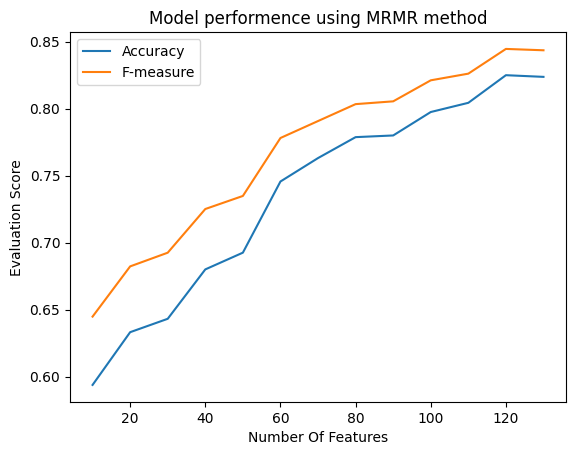

In [68]:
dd[["Accuracy","F-measure"]].plot(title="Model performence using MRMR method",xlabel="Number Of Features",ylabel="Evaluation Score")